In [5]:
import pandas as pd
df = pd.read_csv("./data/cleaned_data.csv")

                            OLS Regression Results                            
Dep. Variable:            vital_level   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     1222.
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          1.54e-254
Time:                        21:30:19   Log-Likelihood:                -19222.
No. Observations:               11466   AIC:                         3.845e+04
Df Residuals:                   11464   BIC:                         3.846e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4244      0.022    112.442      0.0

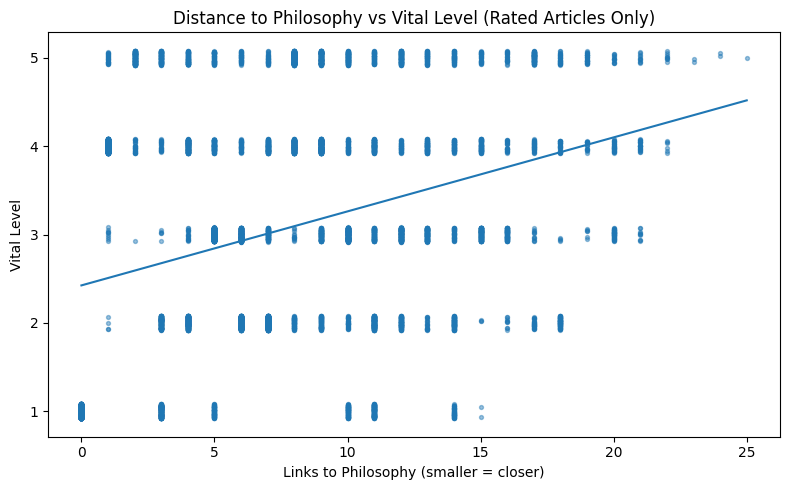

Levene’s test (equal variances?): stat=83.912, p=6.05e-20
Welch’s T-test (means differ?): t=-36.218, p=4.87e-272
Mann–Whitney U (distributions differ?): U=10546134, p=1.63e-250

Chi-square: Near vs HighVital
high_vital  False  True 
near                    
False        1200   4306
True         3090   2870
Chi2=1102.489, p=9.51e-242


/var/folders/l6/y87nw2gx5vbbxz6dv1mplr2h0000gn/T/ipykernel_54694/1168935634.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


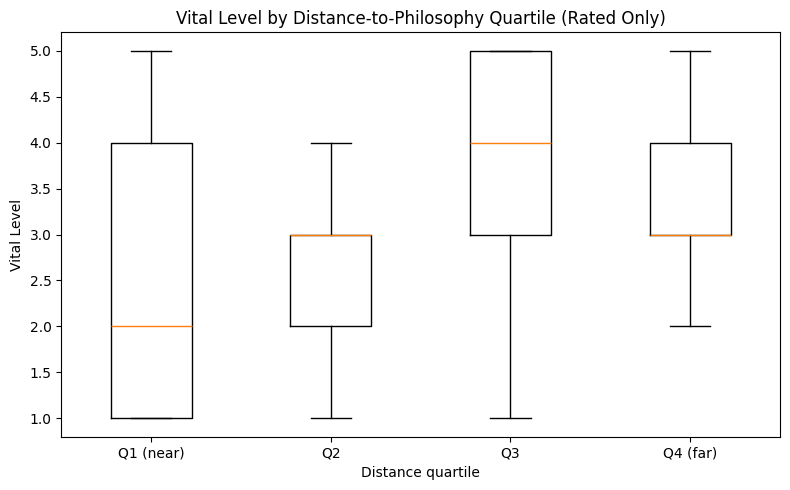

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, levene
# df already exists

# 1) Keep only pages that actually have a vital_level (>0 means rated)
df_filtered = df[df['vital_level'] > 0].copy()

# 2) OLS: Does distance (links_away) relate to vital_level?
X = sm.add_constant(df_filtered['links_away'])
y = df_filtered['vital_level']
ols = sm.OLS(y, X).fit()
print(ols.summary())
print("Interpretation: a significantly NEGATIVE slope for links_away would support "
      "‘closer to Philosophy → higher vital level’. Positive/near‑zero slope does not.")

# 3) Scatter with regression line (Matplotlib only)
plt.figure(figsize=(8, 5))
# jitter vital_level slightly so overlapping integers are visible
y_jitter = df_filtered['vital_level'] + np.random.uniform(-0.08, 0.08, size=len(df_filtered))
plt.scatter(df_filtered['links_away'], y_jitter, s=8, alpha=0.45)
# regression line
xline = np.linspace(df_filtered['links_away'].min(), df_filtered['links_away'].max(), 200)
yhat = ols.predict(sm.add_constant(xline))
plt.plot(xline, yhat)
plt.title("Distance to Philosophy vs Vital Level (Rated Articles Only)")
plt.xlabel("Links to Philosophy (smaller = closer)")
plt.ylabel("Vital Level")
plt.tight_layout()
plt.show()

# 4) Define “near” vs “far” and “high vital” thresholds
near_cut = df_filtered['links_away'].median()   # or pick a fixed value (e.g., <=5)
df_filtered['near'] = df_filtered['links_away'] <= near_cut
df_filtered['high_vital'] = df_filtered['vital_level'] >= 3   # adjust if your rubric differs

# 5) Equal-variance check, Welch’s t-test, Mann–Whitney
near_vals = df_filtered.loc[df_filtered['near'], 'vital_level']
far_vals  = df_filtered.loc[~df_filtered['near'], 'vital_level']

lev_stat, lev_p = levene(near_vals, far_vals)
print(f"Levene’s test (equal variances?): stat={lev_stat:.3f}, p={lev_p:.3g}")

t_stat, t_p = ttest_ind(near_vals, far_vals, equal_var=False)  # Welch by default here
print(f"Welch’s T-test (means differ?): t={t_stat:.3f}, p={t_p:.3g}")

u_stat, u_p = mannwhitneyu(near_vals, far_vals, alternative='two-sided')
print(f"Mann–Whitney U (distributions differ?): U={u_stat:.0f}, p={u_p:.3g}")

# 6) Chi-square: Is “near” associated with being “high vital”?
cont = pd.crosstab(df_filtered['near'], df_filtered['high_vital'])
chi2, chi_p, dof, exp = chi2_contingency(cont)
print("\nChi-square: Near vs HighVital")
print(cont)
print(f"Chi2={chi2:.3f}, p={chi_p:.3g}")

# 7) Boxplot of vital_level by distance quartiles (visual group comparison)
df_filtered['dist_bin'] = pd.qcut(df_filtered['links_away'], q=4,
                                  labels=['Q1 (near)', 'Q2', 'Q3', 'Q4 (far)'])
order = ['Q1 (near)', 'Q2', 'Q3', 'Q4 (far)']
data = [df_filtered.loc[df_filtered['dist_bin']==lab, 'vital_level'] for lab in order]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=order, showfliers=False)
plt.title("Vital Level by Distance-to-Philosophy Quartile (Rated Only)")
plt.xlabel("Distance quartile")
plt.ylabel("Vital Level")
plt.tight_layout()
plt.show()

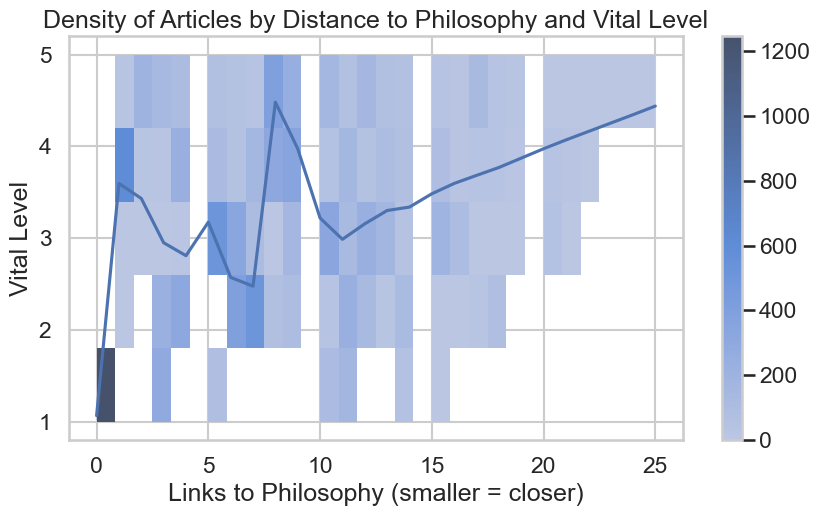

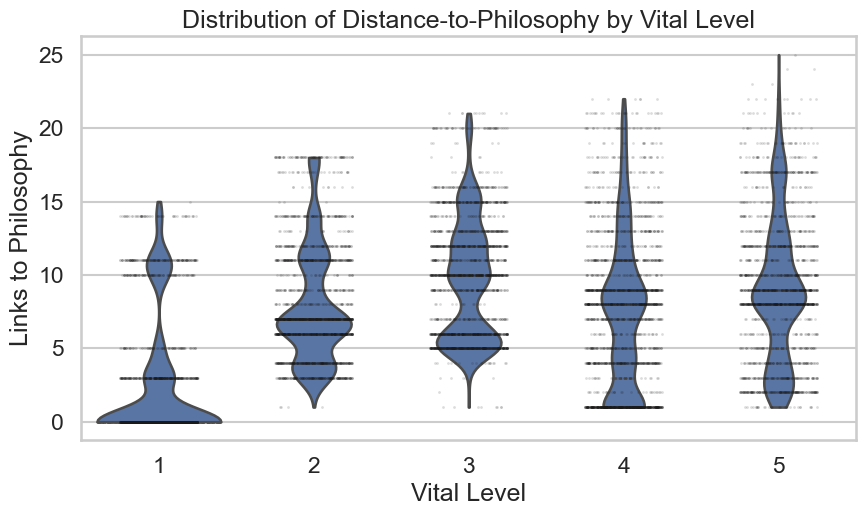

/var/folders/l6/y87nw2gx5vbbxz6dv1mplr2h0000gn/T/ipykernel_54694/3831615290.py:50: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  ax = sns.pointplot(


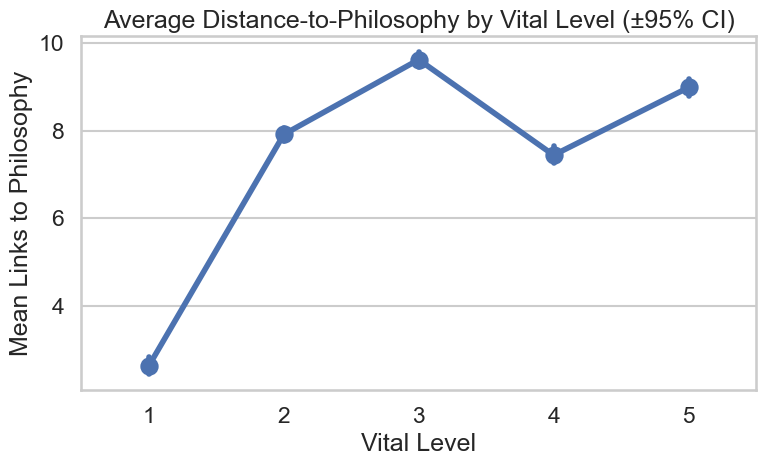

In [8]:
# --- Assumes df_filtered already defined as: df[df['vital_level']>0] ---
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set_theme(style="whitegrid", context="talk")

# Ensure types
df_plot = df_filtered[["links_away", "vital_level"]].dropna().copy()
df_plot["vital_level"] = df_plot["vital_level"].astype(int)
df_plot["links_away"] = df_plot["links_away"].astype(float)

# 1) 2D density heatmap (best for lots of points)
plt.figure(figsize=(9, 5.5))
ax = sns.histplot(
    data=df_plot,
    x="links_away",
    y="vital_level",
    bins=(30, 5),     # 30 bins along distance; 5 vital levels
    cbar=True
)
# Optional LOWESS smooth of median vital vs distance (for the eye)
smoothed = lowess(df_plot["vital_level"], df_plot["links_away"], frac=0.2, return_sorted=True)
plt.plot(smoothed[:,0], smoothed[:,1])
plt.title("Density of Articles by Distance to Philosophy and Vital Level")
plt.xlabel("Links to Philosophy (smaller = closer)")
plt.ylabel("Vital Level")
plt.tight_layout()
plt.show()

# 2) How distance distributes within each vital level (violin with quartiles)
plt.figure(figsize=(9, 5.5))
ax = sns.violinplot(
    data=df_plot,
    x="vital_level",
    y="links_away",
    inner="quartile",
    cut=0
)
sns.stripplot(data=df_plot, x="vital_level", y="links_away", alpha=0.15, color="k", size=2, jitter=0.25)
plt.title("Distribution of Distance-to-Philosophy by Vital Level")
plt.xlabel("Vital Level")
plt.ylabel("Links to Philosophy")
plt.tight_layout()
plt.show()

# 3) Means with 95% CI across vital levels (compact summary)
plt.figure(figsize=(8, 5))
ax = sns.pointplot(
    data=df_plot,
    x="vital_level",
    y="links_away",
    errorbar="ci",   # 95% CI by default
    join=True
)
plt.title("Average Distance-to-Philosophy by Vital Level (±95% CI)")
plt.xlabel("Vital Level")
plt.ylabel("Mean Links to Philosophy")
plt.tight_layout()
plt.show()